# Data Pre-processing for Book Reviews

This notebook details the process of cleaning and preparing the raw book review data from the `Books_gale.csv` file. The primary goals are:

1.  **Load Data**: Import the raw CSV data into a `datasets` object for efficient processing.
2.  **Clean Text**: Apply a series of cleaning steps using regular expressions to remove metadata, junk characters, and formatting issues from the `Full_text` column.
3.  **Calculate Similarity**: Measure how much each text was altered during cleaning by calculating a similarity score between the original and cleaned versions. This helps in quality control.
4.  **Save Results**: Store the cleaned data in a new CSV file for future use and save a smaller sample for manual inspection.
5.  **Analyze & Inspect**: Visualize the distribution of similarity scores and provide a tool to view the "before and after" for texts that were heavily modified.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import difflib
import textwrap
from datasets import load_dataset

### 1. Load Raw Data
We begin by loading the dataset from the specified CSV file using the `datasets` library, which is highly efficient for handling large datasets.


In [4]:
file = 'Books_gale.csv'
folder = './Data'
dataset = load_dataset("csv", data_files=folder + '/' + file)

In [8]:
print(len(dataset['train']['Full_text']) )

'''
with open("books_text.txt", "a") as f:
    for text in dataset['train']['Full_text']:
        f.write("\n\n--- START OF TEXT PIECE ---\n\n")
        f.write(text)
        f.write("\n\n--- END OF TEXT PIECE ---\n\n")
'''

2283


'\nwith open("books_text.txt", "a") as f:\n    for text in dataset[\'train\'][\'Full_text\']:\n        f.write("\n\n--- START OF TEXT PIECE ---\n\n")\n        f.write(text)\n        f.write("\n\n--- END OF TEXT PIECE ---\n\n")\n'

### 2. Define and Apply Text Cleaning Function

The `clean_text_piece_batched` function is the core of our pre-processing pipeline. It takes a "batch" of texts (a list of strings) and applies several cleaning steps to each one. Using a batched function with `dataset.map()` is much faster than processing texts one by one.

The cleaning process involves three main steps:
1.  **Remove Metadata**: Strips out technical tags like `<NEWPAGE>` and promotional text.
2.  **Remove Noise**: Deletes lines with very few alphabetic characters and removes non-standard characters.
3.  **Fix Formatting**: Corrects hyphenated line breaks, normalizes whitespace, and joins lines that are part of the same paragraph.


In [15]:
def clean_text_piece_batched(batch):
    """
    Cleans a batch of text pieces. This function is designed to work
    with dataset.map(batched=True).
    """
    # 'batch' is a dictionary where each key maps to a LIST of values.
    # We get the list of texts from the 'Full_text' column.
    input_texts = batch['Full_text']
    
    cleaned_texts = [] # This will store our cleaned texts

    # Loop through each text in the input batch
    for text in input_texts:
        # Step 1: Remove distracting metadata and tags
        cleaned_text = re.sub(r'\\', '', text)
        cleaned_text = re.sub(r'<NEWPAGE>', '', cleaned_text)
        cleaned_text = re.sub(r'To buy books at discounted prices,.*?booksfirst', '', cleaned_text, flags=re.DOTALL)
        cleaned_text = re.sub(r'Box office:.*', '', cleaned_text, flags=re.DOTALL)

        # Step 2: Remove patterned noise and junk characters
        lines = cleaned_text.split('\n')
        cleaned_lines = []
        for line in lines:
            if len(re.findall(r'[a-zA-Z]', line)) > 5:
                 cleaned_lines.append(line)
        cleaned_text = '\n'.join(cleaned_lines)

        cleaned_text = re.sub(r'[^a-zA-Z0-9\s\.,;:?!£\'"()]', ' ', cleaned_text)

        # Step 3: Fix structure and formatting
        cleaned_text = re.sub(r'-\n', '', cleaned_text)
        cleaned_text = re.sub(r'(?<!\.)\n', ' ', cleaned_text)
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
        cleaned_text = cleaned_text.strip()
        
        cleaned_texts.append(cleaned_text)

    # The function MUST return a dictionary where the key is the new column name
    # and the value is the list of processed items.
    return {'Cleaned_text': cleaned_texts}

In [16]:
print("\n--- Applying the cleaning ---")
dataset = dataset.map(
    clean_text_piece_batched,
    batched=True,
    batch_size=500 # Process 8 full reviews at a time
)
print("Processing complete.")



--- Applying the cleaning ---
Processing complete.


### 3. Calculate Similarity Score
To understand the impact of our cleaning function, we calculate a similarity score between the original text and the cleaned text. A score of `1.0` means the text was unchanged, while a lower score indicates significant alterations. This is useful for identifying and inspecting reviews that might have been corrupted during the cleaning process.

We use Python's built-in `difflib.SequenceMatcher` for this task, which is efficient and doesn't require external libraries.


In [17]:
# --- 2. Define the SequenceMatcher comparison function ---
def calculate_similarity(text_a: str, text_b: str) -> float:
    """
    Calculates a similarity ratio between two strings using SequenceMatcher.
    Returns a float between 0.0 (totally different) and 1.0 (identical).
    """
    # Ensure inputs are strings to avoid errors
    if not isinstance(text_a, str) or not isinstance(text_b, str):
        return 0.0
    
    # Calculate and return the similarity ratio
    return difflib.SequenceMatcher(None, text_a, text_b).ratio()

# --- 3. Define the Mapping Function for Batch Processing ---
def add_similarity_in_batch(examples):
    """
    This function is designed for .map(batched=True).
    'examples' is a dictionary where each value is a LIST of items.
    """
    # Use a list comprehension with zip to efficiently process the batch.
    # This pairs up each 'Full_text' with its corresponding 'Cleaned_text'.
    similarity_scores = [
        calculate_similarity(original, cleaned)
        for original, cleaned in zip(examples['Full_text'], examples['Cleaned_text'])
    ]
    
    # Return a dictionary with the new column. The value must be a list.
    return {'similarity_score': similarity_scores}


# --- 4. Apply the Mapping ---
print("--- Applying the similarity calculation using batching ---")

dataset = dataset.map(
    add_similarity_in_batch,
    batched=True,
    batch_size=500  # For CPU tasks, a larger batch size is fine
)



--- Applying the similarity calculation using batching ---


### 4. Save the Processed Dataset
After cleaning and analysis, we save the processed data. Two files are created:
- `Books_cleaned.csv`: The complete dataset with the new `Cleaned_text` and `similarity_score` columns.
- `Books_cleaned_{no_samples}_samples.csv`: A smaller, random sample of the dataset, which is useful for quick manual checks and validation.


In [18]:
print("\n--- Saving results ---")
dataset['train'].to_csv("Data_processed/rule_based/Books_cleaned.csv", index=False)
print("File saved.")

no_samples = 100
print(f"\n--- Saving a dataset of {no_samples} samples for manual inspection ---")
sample_dataset = dataset['train'].shuffle(seed=42).select(range(no_samples))
sample_dataset.to_csv(f"Data_processed/rule_based/Books_cleaned_{no_samples}_samples.csv", index=False)
print("File saved.")



--- Saving results ---


Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

File saved.

--- Saving a dataset of 100 samples for manual inspection ---


Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

File saved.


### 5. Analyze and Inspect Cleaning Results
Finally, we analyze the results of the cleaning process.

First, we plot a **histogram** of the similarity scores. This gives us a high-level view of how much the texts were changed on average. A distribution skewed towards `1.0` is a good sign.

Second, we define a `pretty_print_side_by_side` function to visually compare the original and cleaned versions of a single review. We use this to inspect the reviews with the **lowest similarity scores** to ensure our cleaning logic is working as expected and not deleting important content.


(array([  1.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          2.,   0.,   1.,   1.,   0.,   1.,   0.,   2.,   2.,   1.,   3.,
          0.,   3.,   1.,   1.,   3.,   1.,   1.,   0.,   4.,   3.,   4.,
          1.,   1.,   5.,   5.,   9.,   9.,   6.,  16.,  16.,  13.,  25.,
         46.,  58.,  96., 297., 836., 806.]),
 array([0.09245742, 0.11058822, 0.12871902, 0.14684983, 0.16498063,
        0.18311143, 0.20124223, 0.21937303, 0.23750383, 0.25563463,
        0.27376544, 0.29189624, 0.31002704, 0.32815784, 0.34628864,
        0.36441944, 0.38255024, 0.40068105, 0.41881185, 0.43694265,
        0.45507345, 0.47320425, 0.49133505, 0.50946585, 0.52759666,
        0.54572746, 0.56385826, 0.58198906, 0.60011986, 0.61825066,
        0.63638146, 0.65451227, 0.67264307, 0.69077387, 0.70890467,
        0.72703547, 0.74516627, 0.76329707, 0.78142788, 0.79955868,
        0.81768948, 0.83582028, 0.85395108, 0.87208188, 0.89021268,
        0.90834349, 0.92647429, 0.94460509, 0.

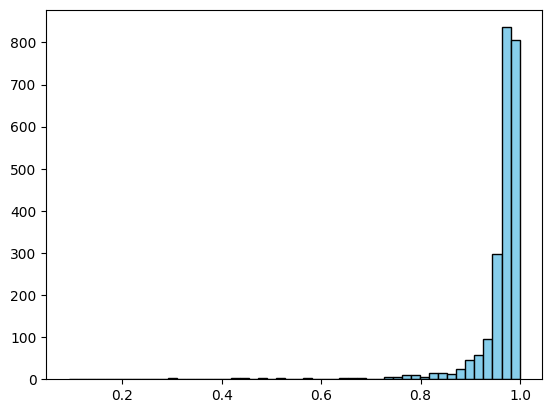

In [19]:
plt.hist(dataset['train']['similarity_score'], bins=50, color='skyblue', edgecolor='black')

In [20]:
df_sorted = dataset['train'].to_pandas().sort_values(by='similarity_score')
# Filter for the most heavily altered reviews
upper_threshold = 0.6
lower_threshold = 0.0
suspicious_reviews = df_sorted[df_sorted['similarity_score'].between(lower_threshold, upper_threshold, inclusive='neither')]
#suspicious_reviews = df_sorted[df_sorted['similarity_score'] <0.6]

print(f"Found {len(suspicious_reviews)} reviews with a similarity score between {lower_threshold} and {upper_threshold} to inspect.")

Found 26 reviews with a similarity score between 0.0 and 0.6 to inspect.


In [21]:
# --- The Side-by-Side Pretty Print Function ---
def pretty_print_side_by_side(review_series, total_width=120):
    """
    Prints a side-by-side comparison of the pre-cleaned original text and
    the final roBERTa-restored text for a single review.

    Args:
        review_series (pd.Series): A single row from your DataFrame.
        total_width (int): The total width of the output in characters.
    """
    # Calculate the width for each text column
    divider = "   |   "
    col_width = (total_width - len(divider)) // 2

    # Get the two versions of the text
    original = review_series['Full_text']
    cleaned = review_series['Cleaned_text']
    
    # Wrap the text in each column into lists of lines
    original_lines = textwrap.wrap(original, width=col_width)
    cleaned_lines = textwrap.wrap(cleaned, width=col_width)
    
    # --- Start Printing ---
    print("=" * total_width)
    # Use .get() to avoid an error if 'similarity_score' doesn't exist
    score = review_series.get('similarity_score', 'N/A')
    if isinstance(score, float):
        score = f"{score:.4f}"
    print(f"Similarity Score: {score}".center(total_width))
    print("-" * total_width)
    
    # Print headers
    header_original = "Original".center(col_width)
    header_cleaned = "Cleaned text".center(col_width)
    print(f"{header_original}{divider}{header_cleaned}")
    print("-" * total_width)

    # Print the lines side-by-side
    max_lines = max(len(original_lines), len(cleaned_lines))
    for i in range(max_lines):
        # Get the line for each side, or an empty string if one side is shorter
        left_line = original_lines[i] if i < len(original_lines) else ""
        right_line = cleaned_lines[i] if i < len(cleaned_lines) else ""
        
        # Print the formatted line with padding
        print(f"{left_line:<{col_width}}{divider}{right_line:<{col_width}}")
        
    print("=" * total_width + "\n")

In [22]:
pretty_print_side_by_side(suspicious_reviews.iloc[6])

                                                Similarity Score: 0.3388                                                
------------------------------------------------------------------------------------------------------------------------
                        Original                           |                         Cleaned text                      
------------------------------------------------------------------------------------------------------------------------
SOME .NEW BOOKS GUSTAV STRESEAIANN: His Diaries,           |   SOME .NEW BOOKS GUSTAV STRESEAIANN: His Diaries,        
Letters, and Papeis. - Tranislated by Eric Sutton.         |   Letters, and Papeis. Tranislated by Eric Sutton.        
(Mlacmillan. 25s.) MARY TUDOR. By Beatrice White.          |   (Mlacmillan. 25s.) MARY TUDOR. By Beatrice White.       
(Macmillan. 15s.) GRACIOUS LADY: The Life of Sara Delano   |   (Macmillan. GRACIOUS LADY: The Life of Sara Delano Roose
Roose- velt. By Rita Halle Klceman. (